In [17]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.model_selection import train_test_split
import boto3
import numpy as np
import sagemaker.amazon.common as smac
import io
from io import StringIO
import sagemaker
from sagemaker import get_execution_role
import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score, precision_score, recall_score
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import s3_input, Session
import os
from sagemaker.predictor import csv_serializer, json_deserializer

In [2]:
# download the data
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

## 1. Data Preparation

In [3]:
data.columns = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
                "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
                "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
                "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst", 
                "perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst", 
                "concave points_worst","symmetry_worst","fractal_dimension_worst"] 

In [4]:
df = data.drop(columns={"id"},axis=1)
df['diagnosis']=df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.shape

(569, 31)

In [6]:
X = df.copy()
X.drop(columns=['diagnosis'], axis=1, inplace=True)
y = df['diagnosis']

In [7]:
# create a holdout set, 20%
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.20)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_holdout.shape)
print(y_holdout.shape)

(455, 30)
(455,)
(114, 30)
(114,)


## 2.1 Training Linear model

In [50]:
bucket = 'uncc-bucket'
filename = 'wdbc.data'
train_path = f"ml-lab/{filename}"
s3_train_data = f"s3://{bucket}/{train_path}"
output_location = f's3://{bucket}/ml-lab/output'

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(X_train).astype('float32'), np.array(y_train).astype('float32'))
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f'{train_path}').upload_fileobj(buf)

In [51]:
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [52]:
sess = sagemaker.Session()
role = get_execution_role()
linear = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.m5.large',
                                   output_path=output_location,
                                   sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=30,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data}, job_name=f"job-abalone-{int(time.time())}")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-22 15:01:46 Starting - Starting the training job...
2020-10-22 15:01:48 Starting - Launching requested ML instances.........
2020-10-22 15:03:20 Starting - Preparing the instances for training...
2020-10-22 15:04:03 Downloading - Downloading input data...
2020-10-22 15:04:27 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/22/2020 15:05:01 INFO 140123020961600] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'in


2020-10-22 15:05:03 Uploading - Uploading generated training model
2020-10-22 15:05:44 Completed - Training job completed
Training seconds: 101
Billable seconds: 101


In [53]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [54]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer


In [55]:
result = linear_predictor.predict(X_holdout.values)

In [56]:
predictions = []
for array in np.array_split(X_holdout.values, 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

## 2.2 Evaluation Metrics for  Linar Model 

In [57]:
auc = metrics.roc_auc_score(y_holdout, predictions)
accuracy = metrics.accuracy_score(y_holdout, predictions)
print(classification_report(y_holdout, predictions))
print('AUC:',auc)
print('Accuracy:',accuracy)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        46

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

AUC: 0.9891304347826086
Accuracy: 0.9912280701754386


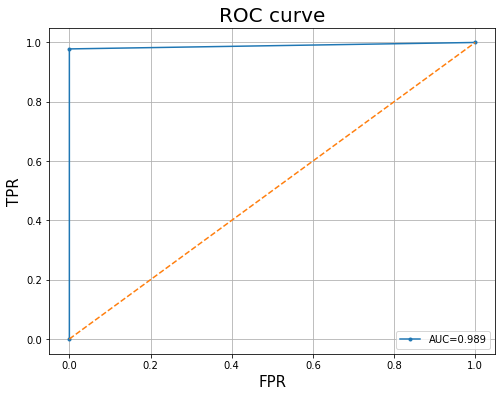

In [58]:
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_holdout, predictions)
auc = metrics.roc_auc_score(y_holdout, predictions)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
#plt.show()
plt.savefig("Roc_curve.jpg", dpi=100)

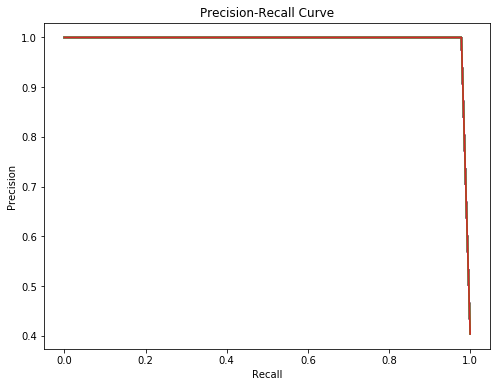

In [59]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(y_holdout, predictions)
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None,figsize=(8,6), facecolor='w', edgecolor='k')
plt.plot(*precision_recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## 3.1 Train XGBoost

In [62]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.20)

# combining train inputs and labels for xgboost
train = pd.concat([y_train, X_train], axis=1)
train.to_csv('train.csv', header=False, index=False)

In [63]:
prefix='ml-lab'
s3_input_train = boto3.Session().resource('s3').Bucket(bucket)\
                .Object(os.path.join(prefix, 'train.csv')).upload_file('train.csv')

In [64]:
s3_train_data = s3_input(f's3://{bucket}/ml-lab/train.csv',content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [65]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
# initialize hyperparameters
hyperparameters = {
        "objective":"binary:logistic",
        "num_round":"200"}

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role=sagemaker.get_execution_role(),
                                    hyperparameters=hyperparameters,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.large',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)


xgb.fit({'train': s3_train_data},job_name=f"job-abalone-{int(time.time())}")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-22 16:28:56 Starting - Starting the training job...
2020-10-22 16:28:59 Starting - Launching requested ML instances......
2020-10-22 16:30:15 Starting - Preparing the instances for training......
2020-10-22 16:31:03 Downloading - Downloading input data...
2020-10-22 16:31:53 Training - Training image download completed. Training in progress.
2020-10-22 16:31:53 Uploading - Uploading generated training model.Arguments: train
[2020-10-22:16:31:52:INFO] Running standalone xgboost training.
[2020-10-22:16:31:52:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-10-22:16:31:52:INFO] File size need to be processed in the node: 0.11mb. Available memory size in the node: 256.43mb
[2020-10-22:16:31:52:INFO] Determined delimiter of CSV input is ','
[16:31:52] S3DistributionType set as FullyReplicated
[16:31:52] 455x30 matrix with 13650 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[16:31:52] src/tree/updater_prune.cc:74: tree pruning end, 


2020-10-22 16:32:00 Completed - Training job completed
Training seconds: 57
Billable seconds: 57


In [66]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.t2.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [67]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


In [68]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions_p = predict(X_holdout.values)
predictions=[round(value) for value in predictions_p]

## 3.2 Validation Metrics for XGBOOST

In [69]:
auc = metrics.roc_auc_score(y_holdout, predictions)
accuracy = metrics.accuracy_score(y_holdout, predictions)
print(classification_report(y_holdout, predictions))
print('AUC:',auc)
print('Accuracy:',accuracy)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       1.00      0.88      0.94        50

    accuracy                           0.95       114
   macro avg       0.96      0.94      0.95       114
weighted avg       0.95      0.95      0.95       114

AUC: 0.94
Accuracy: 0.9473684210526315


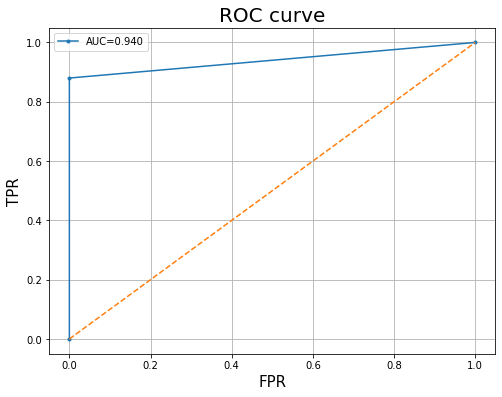

In [70]:
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_holdout, predictions)
auc = metrics.roc_auc_score(y_holdout, predictions)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
#plt.show()
plt.savefig("Roc_curve.jpg", dpi=100)

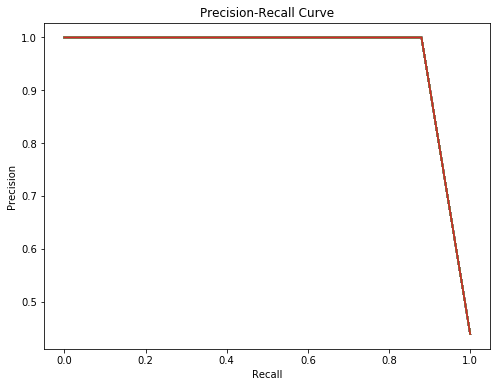

In [71]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(y_holdout, predictions)
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None,figsize=(8,6), facecolor='w', edgecolor='k')
plt.plot(*precision_recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

THe Linear model seem to be performrimg  much better than XGBoost model, sometimes simple models perform better with the simple dataset, however, the linear model may be overfitting to the dataset because it is not using randomized approach/tree based approach like XGBOOST.It needs to be reavaluated by randomly  training and cross validation to compare the AUC between those groups. 

1. <b>LINEAR AUC:</b> AUC: 0.9891304347826086 | Accuracy: 0.9912280701754386
2. <b>XGBOOST AUC:</b> AUC: 0.94 | Accuracy: 0.9473684210526315</br>


Overall, both models are doing great, however, XGBoost seem to provide us realistic results, but It can also be improved with more balanced data and better hyperparameter tunning.